# ISYE-6414 Project Codes

In [32]:
#Libaries used in analyses
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn import tree
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import xport
from imblearn.over_sampling import ADASYN



In [2]:
#Code cell for troubleshooting reading/loading SAS data
df = pd.read_sas('Dataset/Y/DIQ_L.xpt')

/var/folders/qh/tx9bs3110lddb6zdcgqrdpnc0000gn/T/ipykernel_76859/3153294335.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.Value[df_y.DIQ010==3]=1
/var/folders/qh/tx9bs3110lddb6zdcgqrdpnc0000gn/T/ipykernel_76859/3153294335.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.Value[df_y.DIQ010==1]=2
/var/folders/qh/tx9bs3110lddb6zdcgqrdpnc0000gn/T/ipykernel_76859/3153294335.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

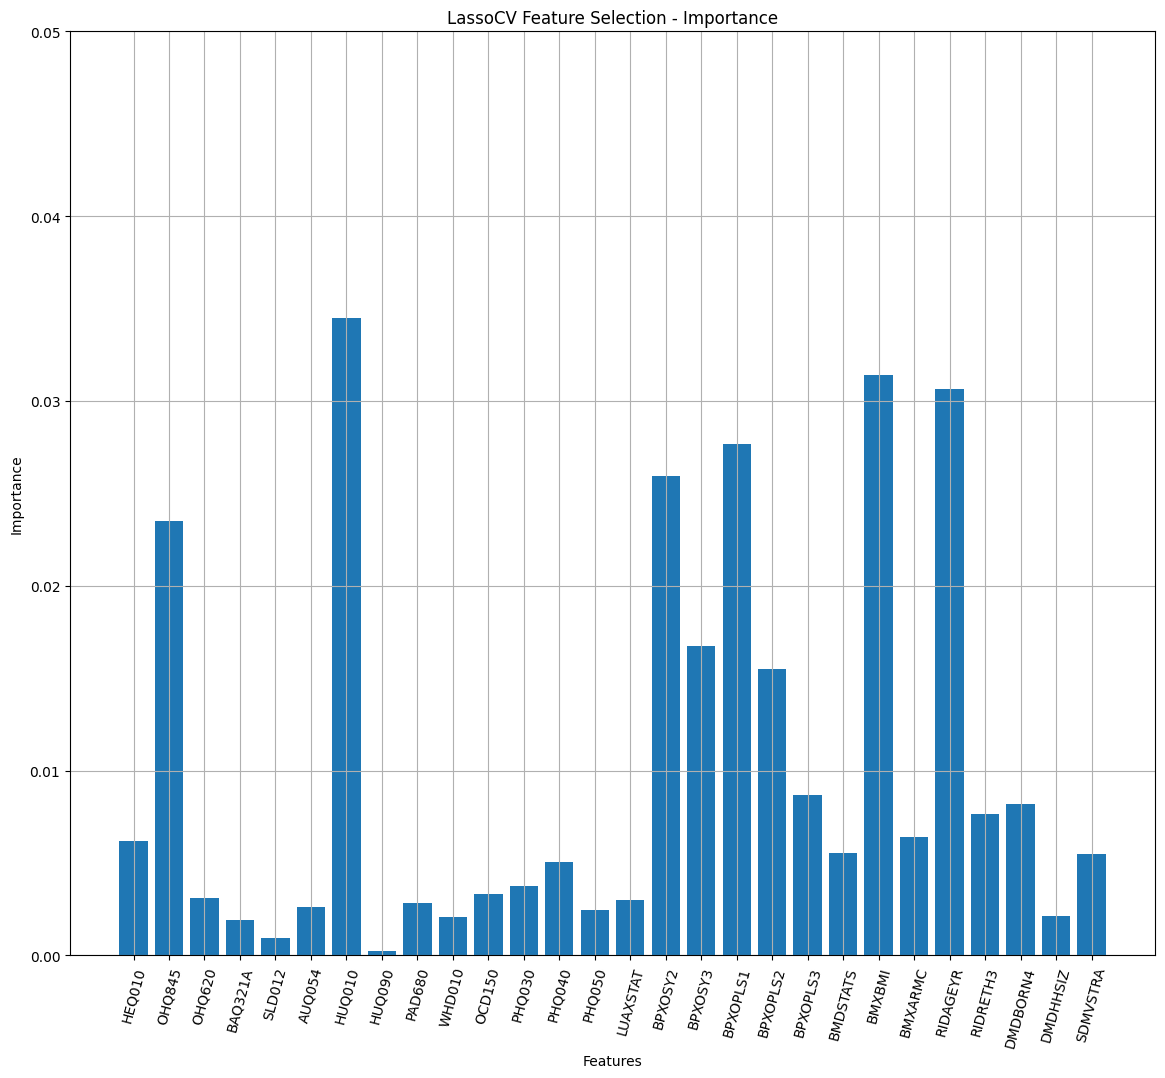

LassoCV CV n: 10
LassoCV alpha: 0.0021
LassoCV MSE: 0.0894
LassoCV R²: 0.2166


In [3]:
#Group Code for Making main dataframes df_x and df_y for individual analysis
#My Goal: df_x should be < 40 years old

column_threshold = 0.05 # percentage of column missing values allowed
row_threshold = 0.2 # percentage of row missing values allowed
lasso_cv=10

base_dir = os.getcwd()
folder_path_Y= os.path.join(base_dir, 'Dataset/Y')
df_y = None


for filename in os.listdir(folder_path_Y):
    if filename.endswith('.xpt'):
        file_path = os.path.join(folder_path_Y, filename)
        df = pd.read_sas(file_path, format='xport')
        
    
        if 'SEQN' not in df.columns:
            continue
        if df_y is None:
            df_y = df
        else:
            df_y = pd.merge(df_y, df, on='SEQN', how='outer', suffixes=('_left', '_right'))

df_y['Value']=0
df_y.Value[df_y.DIQ010==3]=1
df_y.Value[df_y.DIQ010==1]=2

df_y['feat_selection']=0
df_y.feat_selection[df_y.DIQ010==1]=1


folder_path_Questionnaire_Data= os.path.join(base_dir, 'Dataset/X/Questionnaire Data')
folder_path_Laboratory_Data= os.path.join(base_dir, 'Dataset/X/Laboratory Data')
folder_path_Demo_Data= os.path.join(base_dir, 'Dataset/X/Demographic Variables and Sample Weights')
# folder_path_Dietary_Data= os.path.join(base_dir, 'Dataset/X/Dietary Data')
folder_path_Examination_Data= os.path.join(base_dir, 'Dataset/X/Examination Data')

# folder_path_Data=[folder_path_Questionnaire_Data, folder_path_Laboratory_Data, folder_path_Demo_Data, 
#                   folder_path_Dietary_Data, folder_path_Examination_Data]
folder_path_Data=[folder_path_Questionnaire_Data, folder_path_Laboratory_Data,  
                   folder_path_Examination_Data, folder_path_Demo_Data]

# folder_path_Data=[folder_path_Examination_Data]

df_x = None
columns_to_rename = ['DRDINT', 'DRABF', 'WTDR2D', 'WTDRD1','WTPH2YR']

dropped_columns = []
files_to_exclude=[]

for folder_path in folder_path_Data:
    for filename in os.listdir(folder_path):
        if filename.endswith('.xpt'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_sas(file_path, format='xport')
            if df.columns.isin(columns_to_rename).any():
                df = df.rename(columns={col: col+filename for col in columns_to_rename if col in df.columns})        
            
            if 'SEQN' not in df.columns:
                continue
            df_sub=df[df['SEQN'].isin(df_y['SEQN'])]
            if (df_sub.shape[0]>df_y.shape[0]):
                files_to_exclude.extend([filename])
                continue
            

            df_sub=df_sub.select_dtypes(exclude=['object', 'category'])
            
            #delete columns with more than column_threshold % missing values
            missing = df_sub.isna().mean() 
            cols_to_drop = missing[missing > column_threshold].index
            df_sub=df_sub.drop(columns=cols_to_drop)
            dropped_columns.extend([filename, cols_to_drop])
            
            #delete columns with unique value
            cols_to_drop = df_sub.columns[df_sub.nunique() == 1]
            dropped_columns.extend([filename, cols_to_drop])
            df_sub = df_sub.drop(columns=cols_to_drop)
            
              
            if df_x is None:
                df_x = pd.merge(df_y[['SEQN','Value','feat_selection']], df_sub,  how='left', on='SEQN',suffixes=('_x', '_y'))
            else:
                df_x = pd.merge(df_x, df_sub,  how='left', on='SEQN',suffixes=('_x', '_y'))
            



df_x = df_x.drop_duplicates()

#Loosly delete columns with more than 50% missing values
#This drops largely sparse columns
missing = df_x.isna().mean() 
cols_to_drop = missing[missing > 0.5].index
df_x=df_x.drop(columns=cols_to_drop)
dropped_columns.extend([filename, cols_to_drop])

# Drop rows with more than row_threshold% missing values
threshold = (1 - row_threshold) * df_x.shape[1]
df_x = df_x.dropna(thresh=threshold)
df_x.reset_index(drop=True, inplace=True)

X = df_x.drop(columns=['SEQN','feat_selection','Value'])
y = df_x['feat_selection']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
 

pipeline = Pipeline([('imp', SimpleImputer(strategy='median')),       
                     ('scaler', StandardScaler()),                     
                     ('lassoCV', LassoCV(cv=lasso_cv, random_state=1))])

pipeline.fit(X_train, y_train)
lassoCV = pipeline.named_steps['lassoCV']
# sns.set_theme()
# plt.plot(lassoCV.alphas_, lassoCV.mse_path_.mean(axis=1), color='green', marker='o')
# plt.axvline(lassoCV.alpha_,label=f"Best alpha: {round(lassoCV.alpha_,3)}")
# plt.xlabel("alpha")
# plt.ylabel("MSE")
# plt.title("LassoCV Feature Selection - MSE")
# plt.legend()
# plt.grid(True)
# plt.show()

alpha=lassoCV.alpha_
coeffs=lassoCV.coef_
features = X.columns

# plotting the Column Names and Importance of Columns. 
plt.figure(figsize=(14, 12))
plt.bar(features[np.abs(coeffs>0.0001)], np.abs(coeffs[np.abs(coeffs>0.0001)]))
plt.xticks(rotation=75)
plt.grid()
plt.title("LassoCV Feature Selection - Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.05)
plt.grid(True)
plt.show()


X_test_transformed = pipeline.named_steps['scaler'].transform(
    pipeline.named_steps['imp'].transform(X_test)
)
y_pred = pipeline.named_steps['lassoCV'].predict(X_test_transformed)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("LassoCV CV n:", lasso_cv)
print("LassoCV alpha:", round(alpha,4))
print("LassoCV MSE:", round(mse,4))
print("LassoCV R²:", round(r2,4))


model = SelectFromModel(pipeline.named_steps['lassoCV'], prefit=True)
features = X.columns[model.get_support()]


#Including individual portion for analysis: filter only age less than 40 years old
#Also group decision to remove any borderline response (Value = 1) to make results binary
df_x = df_x.loc[df_x['RIDAGEYR'] < 40]
df_x = df_x.loc[df_x['Value'] != 1]
df_x.loc[df_x['Value'] == 2, 'Value'] = 1

#Set predictor and response dataframes
df_y=df_x['Value']
df_x=df_x[features]


 
#Delete columns with more than column_threshold% missing values
missing = df_x.isna().mean() 
cols_to_drop = missing[missing > column_threshold].index
df_x=df_x.drop(columns=cols_to_drop)
dropped_columns.extend([filename, cols_to_drop])  

In [4]:
#Cell for creating a mapping of columns to make them more readable/interpretable

df_x.columns

column_map = {
    'RXQ033':'Prescription_Past_30_Days',
    'HEQ010':'HBV',
    'OHQ845':'Rate_Teeth',
    'OHQ620':'Oral_Pain_Past_Year',
    'HIQ011':'Health_Insurance',
    'IMQ011':'Hepatitis_A_Vaccine',
    'SLD012':'Hours_Slept_Weekdays',
    'AUQ054':'Rate_Hearing',
    'HUQ010':'Rate_General_Health',
    'HUQ030':'Health_Advisor',
    'HUQ055':'Remote_Consult_Past_Year',
    'HUQ090':'Therapy_Past_Year',
    'PUQ100':'Insecticide_Past_Week',
    'PAD790Q':'Moderate_Intensity_Exercise',
    'PAD680':'Time_Sitting_Per_Day',
    'MCQ010':'Asthma',
    'MCQ053':'Anemia_Treatment_Past_3_Months',
    'WHD010':'Height',
    'BPQ020':'Hypertension',
    'BPQ080':'High_Blood_Cholesterol',
    'BPQ101D':'Medication_For_Cholesterol',
    'OCD150':'Occupation_Past_Week',
    'PHQ030':'Alcohol',
    'PHQ040':'Cold_Remedies',
    'PHQ050':'Antacids_Laxatives',
    'PHAFSTMN':'Last_Consumption_Minutes',
    'LUAXSTAT':'Elastrography_Exam',
    'LUANMTGP':'Measures_Attempted',
    'BPXODI1':'Diastolic_Reading_1',
    'BPXOSY2':'Systolic_Reading_2',
    'BPXODI2':'Diastolic_Reading_2',
    'BPXOSY3':'Systolic_Reading_3',
    'BPXODI3':'Diastolic_Reading_3',
    'BPXOPLS1':'Pulse_Reading_1',
    'BPXOPLS2':'Pulse_Reading_2',
    'BPXOPLS3':'Pulse_Reading_3',
    'BMDSTATS':'Body_Measure_Component_Code',
    'BMXBMI':'BMI',
    'BMXARMC':'Arm_Circumference',
    'RIAGENDR':'Gender',
    'RIDAGEYR':'Age',
    'RIDRETH3':'Hispanic_Origin',
    'DMDBORN4':'Country_of_Birth',
    'DMDHHSIZ':'Household_Size',
    'SDMVSTRA':'Variance_Estimator'
}

In [5]:
#Mapping with mapping information created above
df_x = df_x.rename(columns = column_map)
df_x.columns

Index(['Prescription_Past_30_Days', 'HBV', 'Rate_Teeth', 'Oral_Pain_Past_Year',
       'Health_Insurance', 'Hepatitis_A_Vaccine', 'Hours_Slept_Weekdays',
       'Rate_Hearing', 'Rate_General_Health', 'Health_Advisor',
       'Remote_Consult_Past_Year', 'Therapy_Past_Year',
       'Insecticide_Past_Week', 'Asthma', 'Anemia_Treatment_Past_3_Months',
       'Height', 'Hypertension', 'High_Blood_Cholesterol',
       'Medication_For_Cholesterol', 'Occupation_Past_Week', 'Alcohol',
       'Cold_Remedies', 'Antacids_Laxatives', 'Last_Consumption_Minutes',
       'Elastrography_Exam', 'Measures_Attempted', 'Diastolic_Reading_1',
       'Systolic_Reading_2', 'Diastolic_Reading_2', 'Systolic_Reading_3',
       'Diastolic_Reading_3', 'Pulse_Reading_1', 'Pulse_Reading_2',
       'Pulse_Reading_3', 'Body_Measure_Component_Code', 'BMI',
       'Arm_Circumference', 'Gender', 'Age', 'Hispanic_Origin',
       'Country_of_Birth', 'Household_Size', 'Variance_Estimator'],
      dtype='object')

In [6]:
#Address NaN values

#Visualize count of null values in columns
print(df_x.isnull().sum())

Prescription_Past_30_Days          0
HBV                                0
Rate_Teeth                         0
Oral_Pain_Past_Year                0
Health_Insurance                   0
Hepatitis_A_Vaccine                0
Hours_Slept_Weekdays               7
Rate_Hearing                       0
Rate_General_Health                0
Health_Advisor                     0
Remote_Consult_Past_Year           0
Therapy_Past_Year                  0
Insecticide_Past_Week              8
Asthma                             0
Anemia_Treatment_Past_3_Months     0
Height                             0
Hypertension                       0
High_Blood_Cholesterol             0
Medication_For_Cholesterol         0
Occupation_Past_Week               0
Alcohol                           13
Cold_Remedies                     13
Antacids_Laxatives                13
Last_Consumption_Minutes          15
Elastrography_Exam                 0
Measures_Attempted                 0
Diastolic_Reading_1               72
S

In [7]:
#Dataframe copy and get column information
columns_na = df_x.columns[df_x.isna().any()].tolist()
df_temp = df_x.copy()

#Median imputation for all columns with NaN values
for column in columns_na:
    df_temp.loc[:,column].fillna(df_temp[column].median(), inplace = True)

print(df_temp.isnull().sum())


Prescription_Past_30_Days         0
HBV                               0
Rate_Teeth                        0
Oral_Pain_Past_Year               0
Health_Insurance                  0
Hepatitis_A_Vaccine               0
Hours_Slept_Weekdays              0
Rate_Hearing                      0
Rate_General_Health               0
Health_Advisor                    0
Remote_Consult_Past_Year          0
Therapy_Past_Year                 0
Insecticide_Past_Week             0
Asthma                            0
Anemia_Treatment_Past_3_Months    0
Height                            0
Hypertension                      0
High_Blood_Cholesterol            0
Medication_For_Cholesterol        0
Occupation_Past_Week              0
Alcohol                           0
Cold_Remedies                     0
Antacids_Laxatives                0
Last_Consumption_Minutes          0
Elastrography_Exam                0
Measures_Attempted                0
Diastolic_Reading_1               0
Systolic_Reading_2          

In [8]:
#Exploratory analysis of dataframe to be tested 

#First, checking how age is stored in the dataframe and verify that they are all < 40
print(df_temp['Age'].unique())

#Checking the ratio of response values
no_diab_ratio = len(df_y.loc[df_y == 0])/len(df_y)*100
print(f'{no_diab_ratio}% of the dataset is where value = 0')

#Check that response values are binary
print(df_y.unique())

#Check length of dataframes
print(len(df_temp))
print(len(df_y))

[34. 27. 31. 33. 39. 26. 18. 16. 17. 19. 24. 38. 22. 30. 29. 32. 28. 20.
 36. 37. 25. 35. 23. 21.]
97.87028073572121% of the dataset is where value = 0
[0 1]
2066
2066


In [9]:
#Split dataset into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(df_temp, df_y, test_size=0.2, random_state=72, stratify=df_y)

#Use ADASYN function to make balanced dataset roughly 50/50 split of response 
adasyn = ADASYN(random_state=1)
x_train, y_train = adasyn.fit_resample(x_train, y_train)
x_test, y_test = adasyn.fit_resample(x_test, y_test)

#Verify results
print(len(y_train.loc[y_train == 0])/len(y_train)*100)
print(len(y_test.loc[y_test == 0])/len(y_test)*100)

print(len(y_train))
print(len(x_train))


49.92281568385304
50.0
3239
3239


In [10]:
#Random Forest Model Building First Cycle
regressor = RandomForestClassifier(n_estimators = 10, random_state = 72, oob_score = True)

rf_model = regressor.fit(x_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [11]:
#Random Forest Prediction and Performance Metrics
y_pred = rf_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
oob_score = rf_model.oob_score_
r2 = r2_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report: {classification_rep}')
print(f'Out-of-Bag Score: {oob_score}')
print(f'R-squared: {r2}')


Accuracy: 0.6938271604938272
Classification Report:               precision    recall  f1-score   support

           0       0.62      1.00      0.77       405
           1       1.00      0.39      0.56       405

    accuracy                           0.69       810
   macro avg       0.81      0.69      0.66       810
weighted avg       0.81      0.69      0.66       810

Out-of-Bag Score: 0.9814757641247298
R-squared: -0.22469135802469142


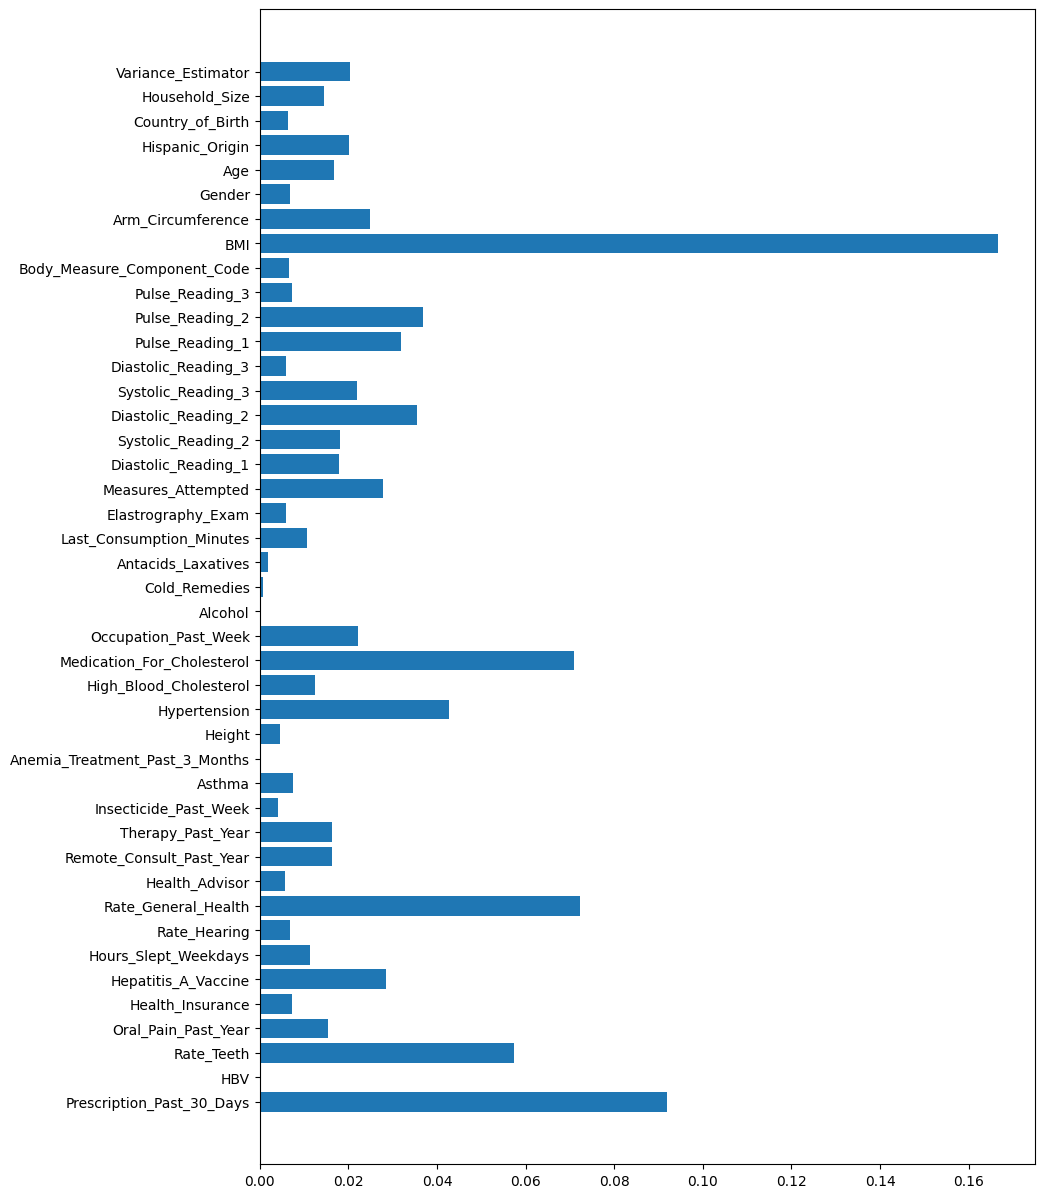

In [12]:
#Visualize Feature Importance
feature_importance = rf_model.feature_importances_

plt.figure(figsize = (10,15))
plt.barh(x_train.columns, feature_importance)
plt.show()

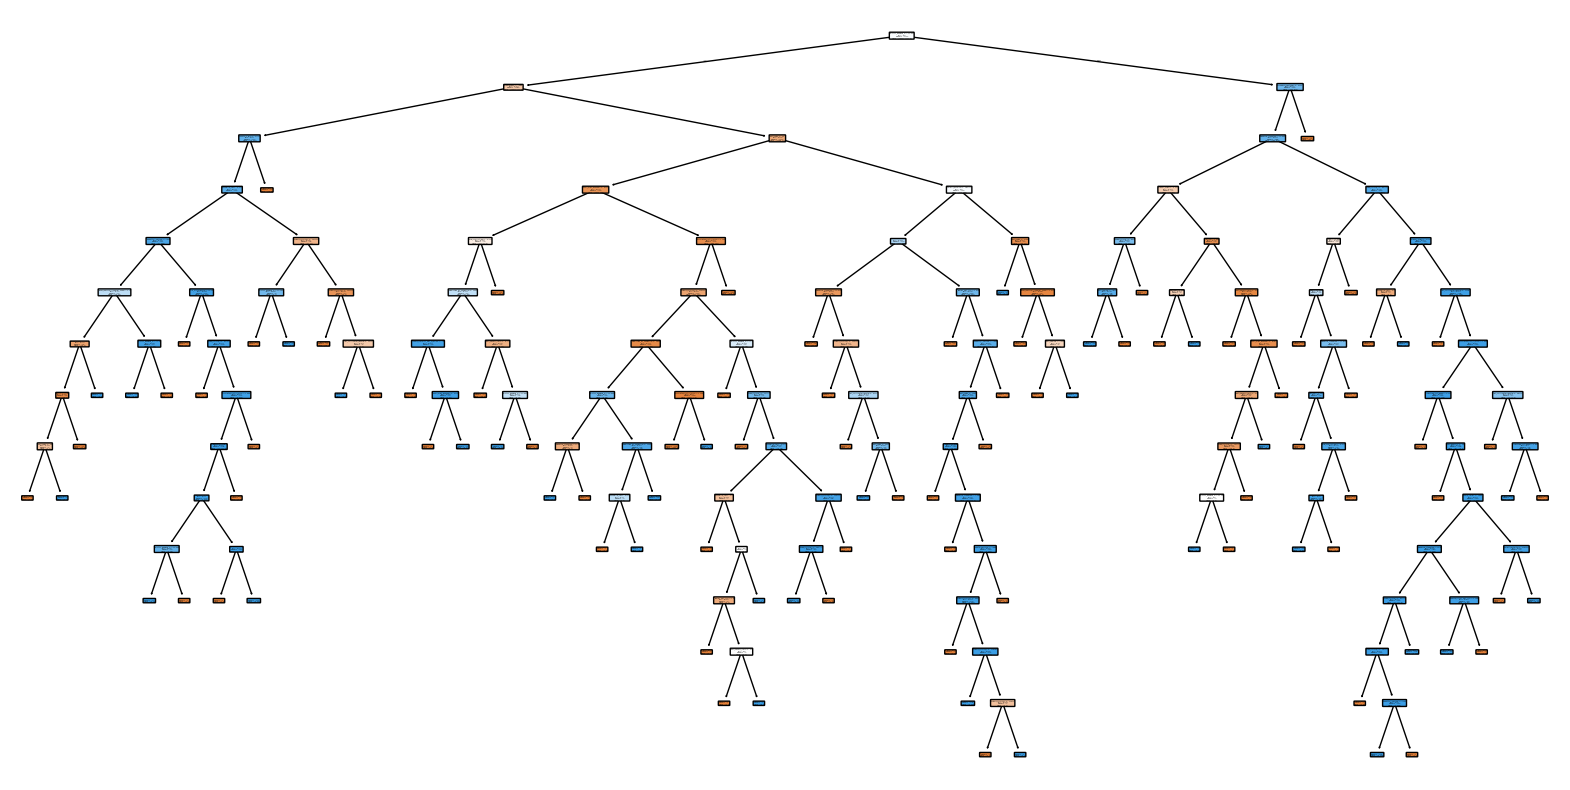

In [13]:
#Visualize Single Tree
plt.figure(figsize = (20,10))
tree.plot_tree(rf_model.estimators_[0], feature_names = df_x.columns, filled = True, rounded = True)
plt.show()

In [14]:
#Cycle 2

#Removing the variables that the Feature Selection deemed as 0 importance
df_temp2 = df_temp.copy()

#Get the index of where feature importance is 0
non_important_index = np.where(feature_importance == 0)

#Drop columns where the importance was 0 
df_temp2 = df_temp2.drop(df_temp2.columns[non_important_index], axis = 1)

In [16]:
#Make another Random Forest Model with new reduced variables

#Split dataset into training and testing datasets
x_train2, x_test2, y_train2, y_test2 = train_test_split(df_temp2, df_y, test_size=0.2, random_state=72, stratify=df_y)

#Use ADASYN function to make balanced dataset roughly 50/50 split of response 
x_train2, y_train2 = adasyn.fit_resample(x_train2, y_train2)
x_test2, y_test2 = adasyn.fit_resample(x_test2, y_test2)


#Random Forest Model Building
regressor2 = RandomForestClassifier(n_estimators = 10, random_state = 72, oob_score = True)

rf_model2 = regressor2.fit(x_train2, y_train2)

#Random Forest Prediction and Performance Metrics
y_pred2 = rf_model2.predict(x_test2)

accuracy = accuracy_score(y_test2, y_pred2)
classification_rep = classification_report(y_test2, y_pred2)
oob_score = rf_model2.oob_score_
r2 = r2_score(y_test2, y_pred2)

print(f'Accuracy: {accuracy}')
print(f'Classification Report: {classification_rep}')
print(f'Out-of-Bag Score: {oob_score}')
print(f'R-squared: {r2}')


Accuracy: 0.7320987654320987
Classification Report:               precision    recall  f1-score   support

           0       0.65      1.00      0.79       405
           1       0.99      0.47      0.64       405

    accuracy                           0.73       810
   macro avg       0.82      0.73      0.71       810
weighted avg       0.82      0.73      0.71       810

Out-of-Bag Score: 0.9796233405372028
R-squared: -0.07160493827160486


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


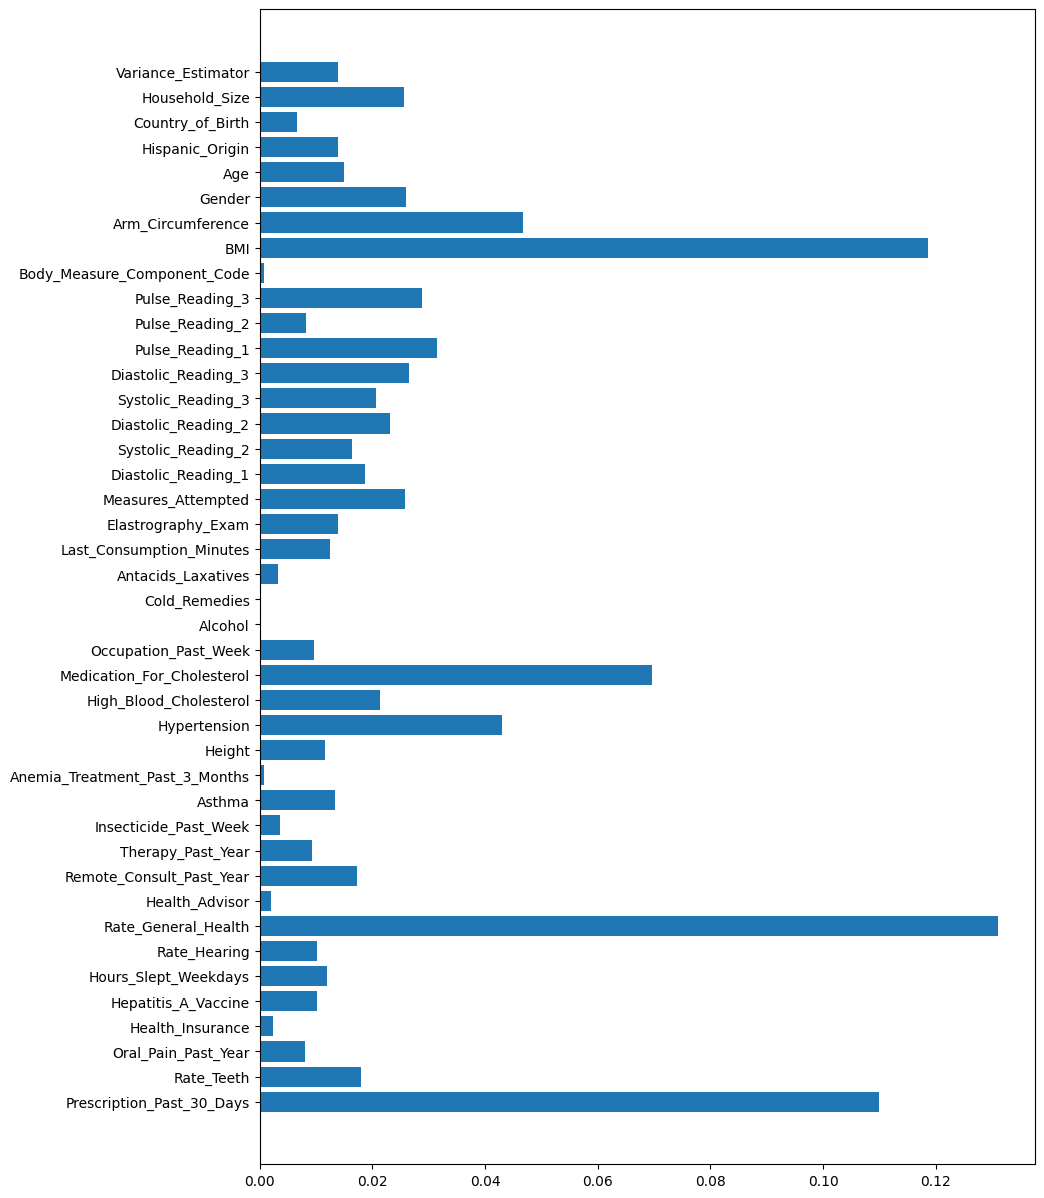

In [17]:
#Visualize Feature Importance Again
feature_importance2 = rf_model2.feature_importances_

plt.figure(figsize = (10,15))
plt.barh(x_train2.columns, feature_importance2)
plt.show()

In [18]:
#Third cycle 

#Removing the variables that the Feature Selection deemed as 0 importance again
df_temp3 = df_temp2.copy()

#Get the index of where feature importance is 0

non_important_index = np.where(feature_importance2 == 0)

#Drop columns where the importance was 0 
df_temp3 = df_temp3.drop(df_temp3.columns[non_important_index], axis = 1)

df_temp3.columns

Index(['Prescription_Past_30_Days', 'Rate_Teeth', 'Oral_Pain_Past_Year',
       'Health_Insurance', 'Hepatitis_A_Vaccine', 'Hours_Slept_Weekdays',
       'Rate_Hearing', 'Rate_General_Health', 'Health_Advisor',
       'Remote_Consult_Past_Year', 'Therapy_Past_Year',
       'Insecticide_Past_Week', 'Asthma', 'Anemia_Treatment_Past_3_Months',
       'Height', 'Hypertension', 'High_Blood_Cholesterol',
       'Medication_For_Cholesterol', 'Occupation_Past_Week', 'Cold_Remedies',
       'Antacids_Laxatives', 'Last_Consumption_Minutes', 'Elastrography_Exam',
       'Measures_Attempted', 'Diastolic_Reading_1', 'Systolic_Reading_2',
       'Diastolic_Reading_2', 'Systolic_Reading_3', 'Diastolic_Reading_3',
       'Pulse_Reading_1', 'Pulse_Reading_2', 'Pulse_Reading_3',
       'Body_Measure_Component_Code', 'BMI', 'Arm_Circumference', 'Gender',
       'Age', 'Hispanic_Origin', 'Country_of_Birth', 'Household_Size',
       'Variance_Estimator'],
      dtype='object')

In [38]:
#Make another Random Forest Model with new reduced variables

#Split dataset into training and testing datasets
x_train3, x_test3, y_train3, y_test3 = train_test_split(df_temp3, df_y, test_size=0.2, random_state=72, stratify=df_y)

#Use ADASYN function to make balanced dataset roughly 50/50 split of response 
adasyn = ADASYN(random_state=1)
x_train3, y_train3 = adasyn.fit_resample(x_train3, y_train3)
x_test3, y_test3 = adasyn.fit_resample(x_test3, y_test3)


#Random Forest Model Building
regressor3 = RandomForestClassifier(n_estimators = 10, random_state = 72, oob_score = True)

rf_model3 = regressor3.fit(x_train3, y_train3)

#Random Forest Prediction and Performance Metrics
y_pred3 = rf_model3.predict(x_test3)
y_pred3_prob = rf_model3.predict_proba(x_test3)[:,1]

accuracy = accuracy_score(y_test3, y_pred3)
classification_rep = classification_report(y_test3, y_pred3)
oob_score = rf_model3.oob_score_
r2 = r2_score(y_test3, y_pred3)

print(f'Accuracy: {accuracy}')
print(f'Classification Report: {classification_rep}')
print(f'Out-of-Bag Score: {oob_score}')
print(f'R-squared: {r2}')


Accuracy: 0.7160493827160493
Classification Report:               precision    recall  f1-score   support

           0       0.64      1.00      0.78       405
           1       1.00      0.43      0.60       405

    accuracy                           0.72       810
   macro avg       0.82      0.72      0.69       810
weighted avg       0.82      0.72      0.69       810

Out-of-Bag Score: 0.9833281877122568
R-squared: -0.1358024691358024


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


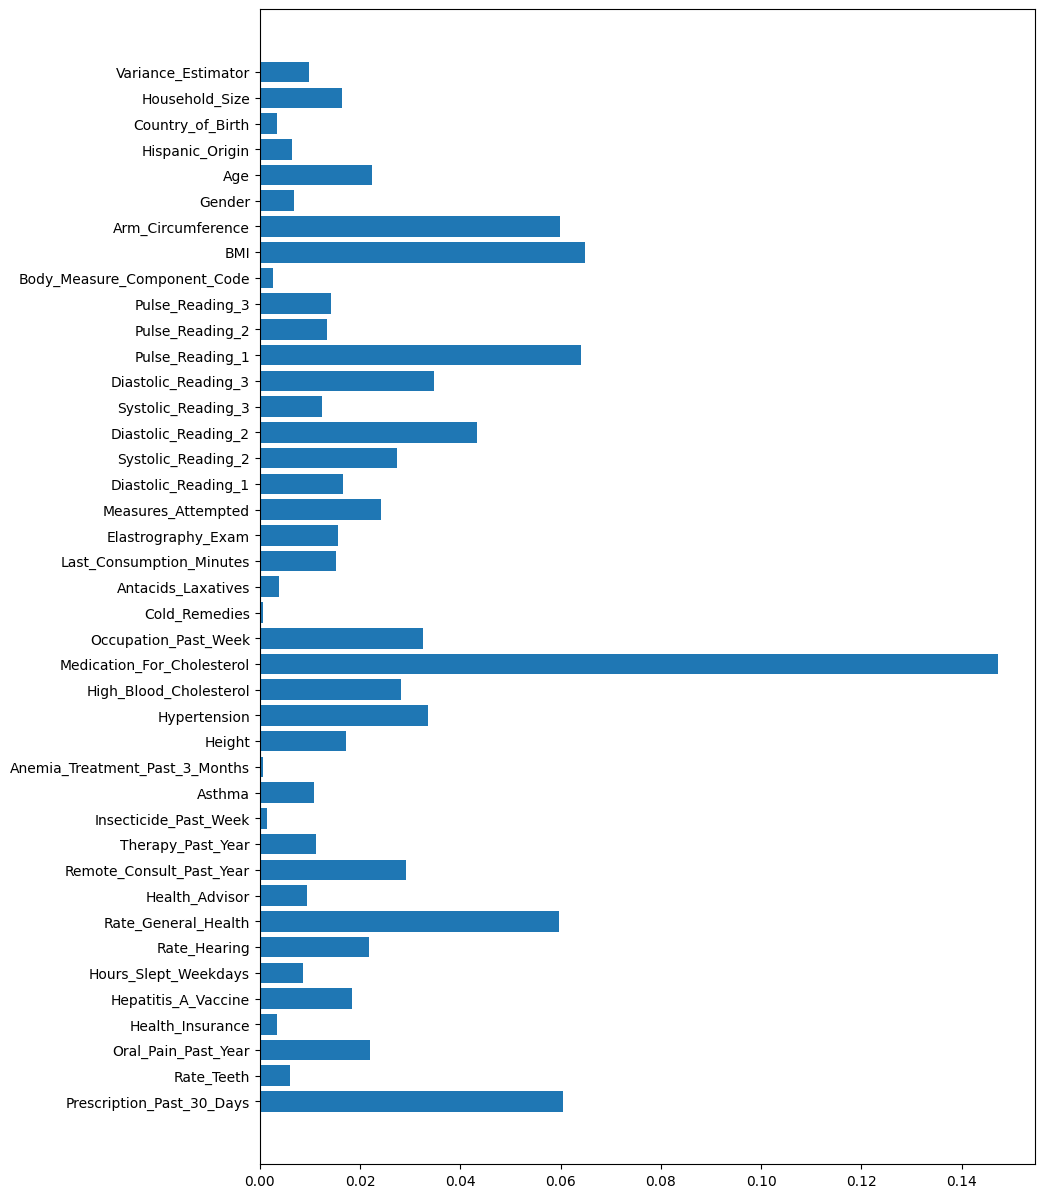

In [29]:
#Visualize Feature Importance Again
feature_importance3 = rf_model3.feature_importances_

plt.figure(figsize = (10,15))
plt.barh(x_train3.columns, feature_importance3)
plt.show()

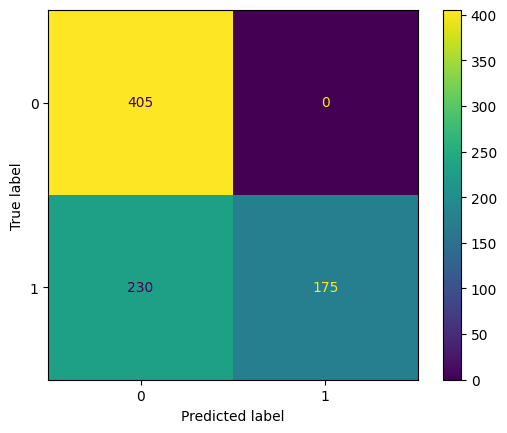

In [30]:
#Confusion Matrix

cm3 = confusion_matrix(y_test3, y_pred3) 
ConfusionMatrixDisplay(confusion_matrix = cm3).plot()
plt.show() 


ROC AUC: 0.9466636183508612


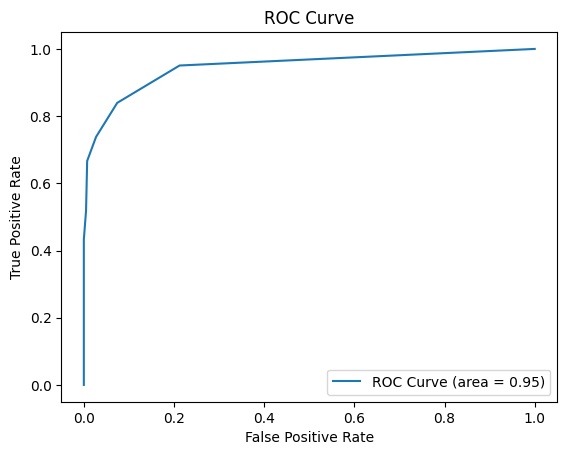

In [39]:
#ROC AUC

fpr, tpr, thresholds = roc_curve(y_test3, y_pred3_prob, pos_label = 1)

roc_auc = roc_auc_score(y_test3, y_pred3_prob)
print(f'ROC AUC: {roc_auc}')

plt.plot(fpr, tpr, label = 'ROC Curve (area = %0.2f)'% roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve')
plt.legend()
plt.show()